# Kafka Producer

---

A notebook that is used on the local machine to connect to the Kafka server and act as the producer.

For the real time anomaly detection project, the producers role is to feed in the data into the Kafka topic "network-data-events". The producer breaks down the data into smaller streams or batches. I have chosen 2% so that the 50% of the remaining data will be streamed in 50 batches.

This is used to simulate a real-time data pipeline where network traffic would be entered in to the models so detection could be found in real time.

For resources, I will only test each 5 batches, starting at 1, 5, 10, 15, etc. The results of each batch (predications or acturally results) will be send to the db each time. To a new table.

**Steps:** (Put here as I develop and improve)
   - 1) Create two Topics: "batch-network-data" and "test-batch-labels".
   - 2) Load second dataset (second 50%, first was used for baseline models).
   - 3) Split data into 50 batches.
   - 4) Split data into the two topics and seperate into features into "test-batches-labels" and the labels into "test-batch-labels". Important: these are accurate.
   - 5) Send two topics to the consumer. The first 5 batches for testing every 10 minutes (as a test).
   

---

##### Libraries

In [53]:
# Libraries in Producer Notebook

# General
import time
import os
import sys
import io

# Data types
import json
import fastavro
from typing import List, Dict

# Data manipulation
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Kafka
from confluent_kafka import Producer

In [54]:
import warnings
warnings.filterwarnings('ignore')

--- 

# Load the second 50% dataset

In [55]:
# Load the data
file_path = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Notebooks\ids_2018_streaming_data.parquet'

# Load the data
data = pd.read_parquet(file_path)

## Explore the loaded data.

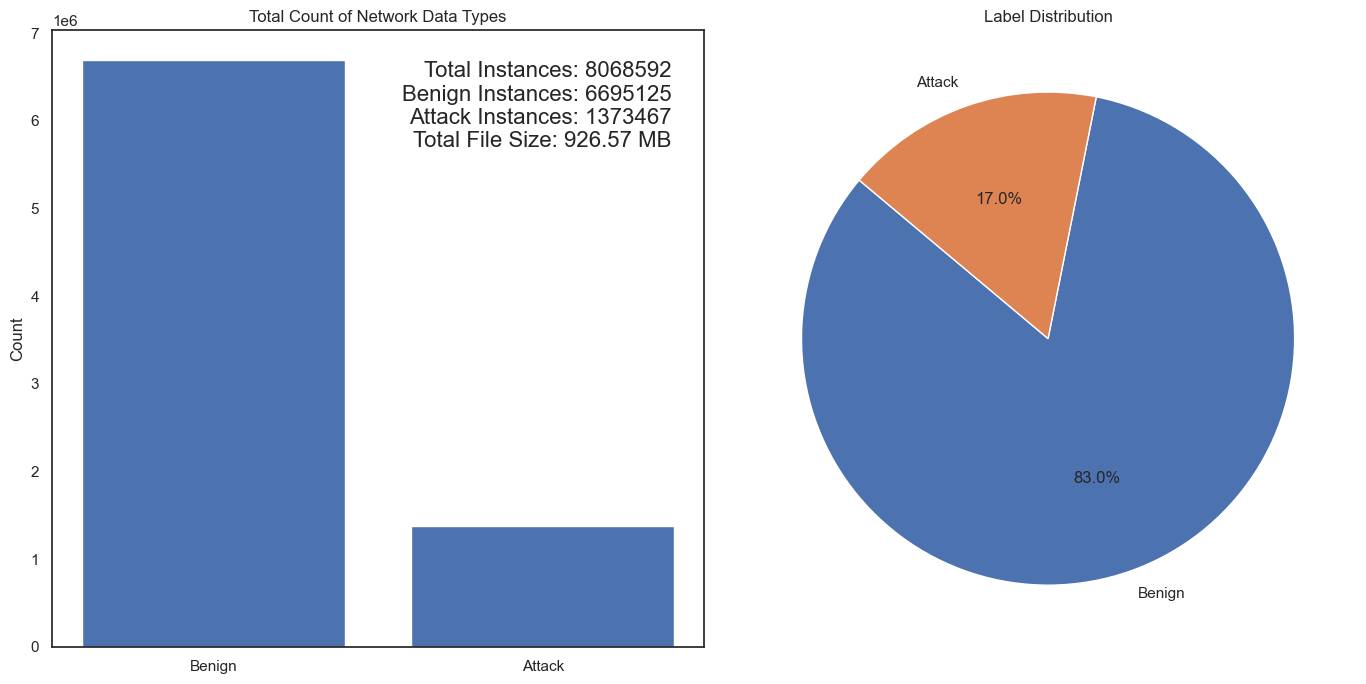

In [56]:
# Plot to get a viusal of the data.

# Apply theme
sns.set_theme(style="white")

# Get value counts for the labels
label_counts = data["Label"].value_counts()

# Calculate total instances and file size
total_instances = len(data)
benign_instances = label_counts.get(0,0)
attack_instances = label_counts.get(1,0)
file_size = os.path.getsize(r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Notebooks\ids_2018_streaming_data.parquet') / (1024 * 1024) # File to Mb

# Information text box content
info_text = f"Total Instances: {total_instances}\n" \
            f"Benign Instances: {benign_instances}\n" \
            f"Attack Instances: {attack_instances}\n" \
            f"Total File Size: {file_size:.2f} MB"

# Create a mapping to change the binary labels to attack or Benign 
plot_labels = {0:"Benign", 1:"Attack"}

# Set up two plots side by side on a 1x2 grid
fig, ax = plt.subplots(1,2, figsize=(14,7))

# Bar plot
ax[0].bar(label_counts.index.map(plot_labels), label_counts.values)
ax[0].set_title("Total Count of Network Data Types")
ax[0].set_ylabel("Count")
# ax[0].set_xticklabels(label_counts.index, rotation=45)

# Pie chart
ax[1].pie(label_counts, labels=label_counts.index.map(plot_labels),
         autopct="%1.1f%%", startangle=140)
ax[1].set_title("Label Distribution")


# Info Box in the bar plot
props = dict(boxstyle='round', facecolor='white', lw=0.5)
# Adjust the position of the text box to fit within the bar plot area
ax[0].text(0.95, 0.95, info_text, transform=ax[0].transAxes, fontsize=16,
           verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

## AVRO objects

In [57]:
# create two functions for the feature and label.

# Function for the features
def features_to_avro (batch, schema):
    avro_data = []
    for _, row in batch.iterrows():
        avro_data.append({
        "Dst Port": row["Dst Port"],
        "Protocol": row["Protocol"],
        "Flow Duration": row["Flow Duration"],
        "Tot Fwd Pkts": row["Tot Fwd Pkts"],
        "Tot Bwd Pkts": row["Tot Bwd Pkts"],
        "TotLen Fwd Pkts": row["TotLen Fwd Pkts"],
        "TotLen Bwd Pkts": row["TotLen Bwd Pkts"],
        "Fwd Pkt Len Max": row["Fwd Pkt Len Max"],
        "Fwd Pkt Len Min": row["Fwd Pkt Len Min"],
        "Fwd Pkt Len Mean": row["Fwd Pkt Len Mean"],
        "Fwd Pkt Len Std": row["Fwd Pkt Len Std"],
        "Bwd Pkt Len Max": row["Bwd Pkt Len Max"],
        "Bwd Pkt Len Min": row["Bwd Pkt Len Min"],
        "Bwd Pkt Len Mean": row["Bwd Pkt Len Mean"],
        "Bwd Pkt Len Std": row["Bwd Pkt Len Std"],
        "Flow Byts/s": row["Flow Byts/s"],
        "Flow Pkts/s": row["Flow Pkts/s"],
        "Flow IAT Mean": row["Flow IAT Mean"],
        "Flow IAT Std": row["Flow IAT Std"],
        "Flow IAT Max": row["Flow IAT Max"],
        "Flow IAT Min": row["Flow IAT Min"],
        "Fwd IAT Tot": row["Fwd IAT Tot"],
        "Fwd IAT Mean": row["Fwd IAT Mean"],
        "Fwd IAT Std": row["Fwd IAT Std"],
        "Fwd IAT Max": row["Fwd IAT Max"],
        "Fwd IAT Min": row["Fwd IAT Min"],
        "Bwd IAT Tot": row["Bwd IAT Tot"],
        "Bwd IAT Mean": row["Bwd IAT Mean"],
        "Bwd IAT Std": row["Bwd IAT Std"],
        "Bwd IAT Max": row["Bwd IAT Max"],
        "Bwd IAT Min": row["Bwd IAT Min"],
        "Fwd PSH Flags": row["Fwd PSH Flags"],
        "Fwd URG Flags": row["Fwd URG Flags"],
        "Fwd Header Len": row["Fwd Header Len"],
        "Bwd Header Len": row["Bwd Header Len"],
        "Fwd Pkts/s": row["Fwd Pkts/s"],
        "Bwd Pkts/s": row["Bwd Pkts/s"],
        "Pkt Len Min": row["Pkt Len Min"],
        "Pkt Len Max": row["Pkt Len Max"],
        "Pkt Len Mean": row["Pkt Len Mean"],
        "Pkt Len Std": row["Pkt Len Std"],
        "Pkt Len Var": row["Pkt Len Var"],
        "FIN Flag Cnt": row["FIN Flag Cnt"],
        "SYN Flag Cnt": row["SYN Flag Cnt"],
        "RST Flag Cnt": row["RST Flag Cnt"],
        "PSH Flag Cnt": row["PSH Flag Cnt"],  
        "ACK Flag Cnt": row["ACK Flag Cnt"],
        "URG Flag Cnt": row["URG Flag Cnt"],
        "CWE Flag Count": row["CWE Flag Count"],
        "ECE Flag Cnt": row["ECE Flag Cnt"],
        "Down/Up Ratio": row["Down/Up Ratio"],
        "Pkt Size Avg": row["Pkt Size Avg"],
        "Fwd Seg Size Avg": row["Fwd Seg Size Avg"],
        "Bwd Seg Size Avg": row["Bwd Seg Size Avg"],
        "Subflow Fwd Pkts": row["Subflow Fwd Pkts"],
        "Subflow Fwd Byts": row["Subflow Fwd Byts"],
        "Subflow Bwd Pkts": row["Subflow Bwd Pkts"],
        "Subflow Bwd Byts": row["Subflow Bwd Byts"],
        "Init Fwd Win Byts": row["Init Fwd Win Byts"],
        "Init Bwd Win Byts": row["Init Bwd Win Byts"],
        "Fwd Act Data Pkts": row["Fwd Act Data Pkts"],
        "Fwd Seg Size Min": row["Fwd Seg Size Min"],
        "Active Mean": row["Active Mean"],
        "Active Std": row["Active Std"],
        "Active Max": row["Active Max"],
        "Active Min": row["Active Min"],
        "Idle Mean": row["Idle Mean"],
        "Idle Std": row["Idle Std"],
        "Idle Max": row["Idle Max"],
        "Idle Min": row["Idle Min"]
        })
    
    buffer =io.BytesIO()
    fastavro.writer(buffer, schema, avro_data)
    return buffer.getvalue()
    
# function for the label
def label_to_avro(batch, schema):
    avro_data = []
    for _, row in batch.iterrows():
        avro_data.append({"Label": row["Label"]})

    buffer = io.BytesIO()
    fastavro.writer(buffer, schema, avro_data)
    return buffer.getvalue()

# First 10% of data - To be Streamed into the producer

It seems unlikley I will be able to use the full dataset at this point. Instead I will take 20% of the data as a sample and use this to create batches which I will then test on the models as a first step.

In [58]:
# Calculate 10% of the main data
sample_size = int(len(data) * 0.1)

# Calculate 10% of the attack instances
attack_data = data[data["Label"] == 1]
num_attack_to_sample = int(len(attack_data) * 0.1)
attack_sample = attack_data.sample(n=num_attack_to_sample)

# Calculate how many benign instances are needed to make up the rest of the 10% sample
benign_data = data[data["Label"] == 0]
num_benign_to_sample = sample_size - len(attack_sample)
benign_sample = benign_data.sample(n=num_benign_to_sample)

# Combine the attack and benign samples
combined_sample = pd.concat([attack_sample, benign_sample])

# Shuffle the combined sample
final_sample = combined_sample.sample(frac=1).reset_index(drop=True)

Final_sample gives me 10% of the data with 10% of the attack and benign instances in it.

In [59]:
# Calculate the total memory usage of the final_sample in bytes
total_memory_bytes = final_sample.memory_usage(deep=True).sum()

# Convert bytes to megabytes (1 MB = 1024 * 1024 bytes)
total_memory_mb = total_memory_bytes / (1024 * 1024)

print(f"Size of final_sample: {total_memory_mb:.2f} MB")

Size of final_sample: 221.61 MB


##### Explore the Sample data

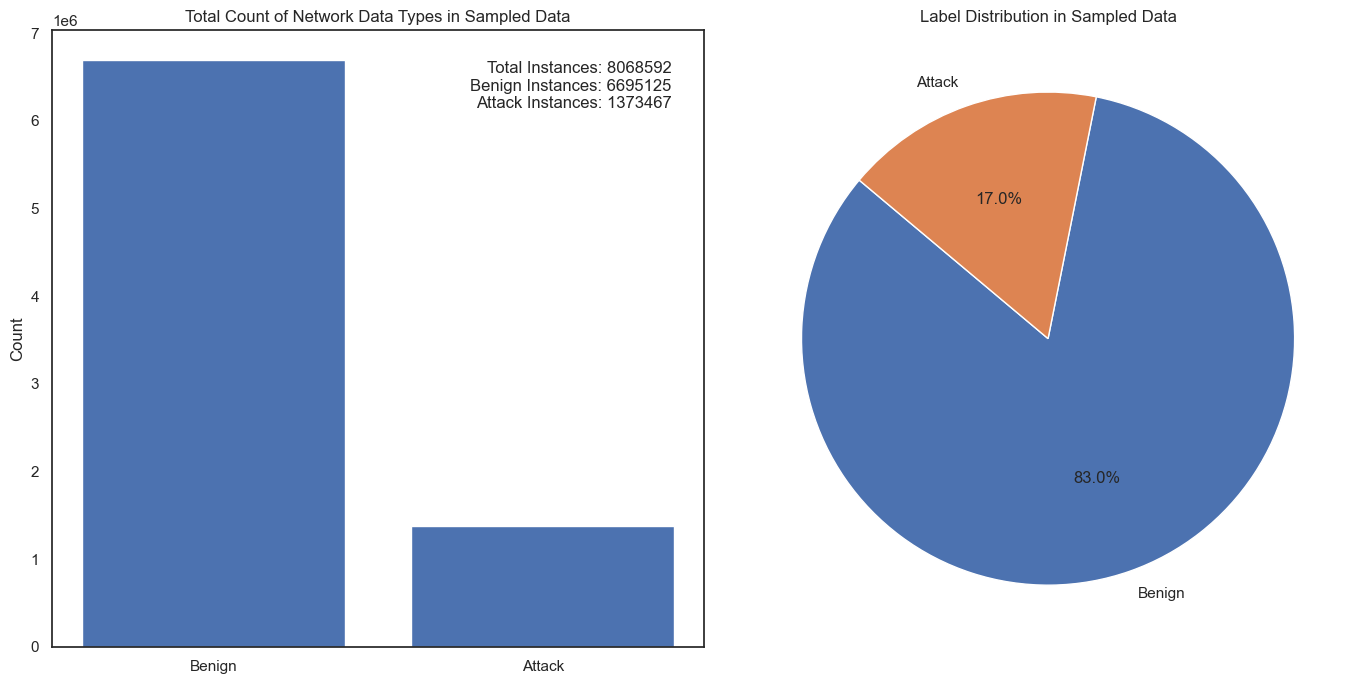

In [60]:
# Apply theme
sns.set_theme(style="white")

# Get value counts for the labels in the sampled data
label_counts = data["Label"].value_counts()

# Calculate total instances
total_instances = len(data)
benign_instances = label_counts.get(0, 0)
attack_instances = label_counts.get(1, 0)

# Information text box content
info_text = f"Total Instances: {total_instances}\n" \
            f"Benign Instances: {benign_instances}\n" \
            f"Attack Instances: {attack_instances}"

# Create a mapping to change the binary labels to "Attack" or "Benign"
plot_labels = {0: "Benign", 1: "Attack"}

# Set up two plots side by side on a 1x2 grid
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Bar plot
ax[0].bar(label_counts.index.map(plot_labels), label_counts.values)
ax[0].set_title("Total Count of Network Data Types in Sampled Data")
ax[0].set_ylabel("Count")

# Pie chart
ax[1].pie(label_counts, labels=label_counts.index.map(plot_labels),
          autopct="%1.1f%%", startangle=140)
ax[1].set_title("Label Distribution in Sampled Data")

# Info Box in the bar plot
props = dict(boxstyle='round', facecolor='white', lw=0.5)
ax[0].text(0.95, 0.95, info_text, transform=ax[0].transAxes, fontsize=12,
           verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()


# **250 batches**

In [61]:
# Shuffle the dataset
final_sample = final_sample.sample(frac=1).reset_index(drop=True)

# split the dataset into the two labels so that each batch can have a mixture.
benign_data = final_sample[final_sample['Label'] == 0]
attack_data = final_sample[final_sample['Label'] == 1]

# Calculate the total number of attack instancs so we know how many to spread across the batches.
total_attack_instances = len(attack_data)

# Number of batches. I choose 250 for now.
batch_size = len(final_sample) // 100

# Randomise the number of instances to place in each batch
attack_distribution = np.random.randint(0, batch_size, size=100)
# Ensure the sum does not exceed the total number of attack instances
while sum(attack_distribution) > total_attack_instances:
    # Scale down the distribution if the sum exceeds the total number of attack instances
    attack_distribution = (attack_distribution / sum(attack_distribution) * total_attack_instances).astype(int)

# Makes the batches
batches = []
for num_attack in attack_distribution:
    # Ensure there are enough attack instances available
    num_attack = min(num_attack, len(attack_data))
    attack_sample = attack_data.sample(n=num_attack, replace=False)
    attack_data = attack_data.drop(attack_sample.index)
    
    # Determine the number of benign instances needed to fill the batch
    num_benign = batch_size - num_attack

    # Ensure there are enough benign instances available
    num_benign = min(num_benign, len(benign_data))
    benign_sample = benign_data.sample(n=num_benign, replace=False) if num_benign > 0 else pd.DataFrame()
    benign_data = benign_data.drop(benign_sample.index)
    
    # Combine the attack and benign samples to form the batch
    batch = pd.concat([attack_sample, benign_sample]).sample(frac=1).reset_index(drop=True)
    batches.append(batch)

In [9]:
# benign_data.info() 

In [62]:
# get the number of batches to check we just have 250 batches
number_of_batches = len(batches)
print(f"The total number of batches is: {number_of_batches}")

The total number of batches is: 100


In [63]:
# Total number of batches
sample_total_rows = sum(batch_sizes)
print("Total number of rows in the batch sample:", sample_total_rows)

Total number of rows in the batch sample: 806800


In [64]:
# Get a list of the batches - they are all the same size which is good.
batch_sizes = [len(batch) for batch in batches]
print(batch_sizes)

[8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068, 8068]


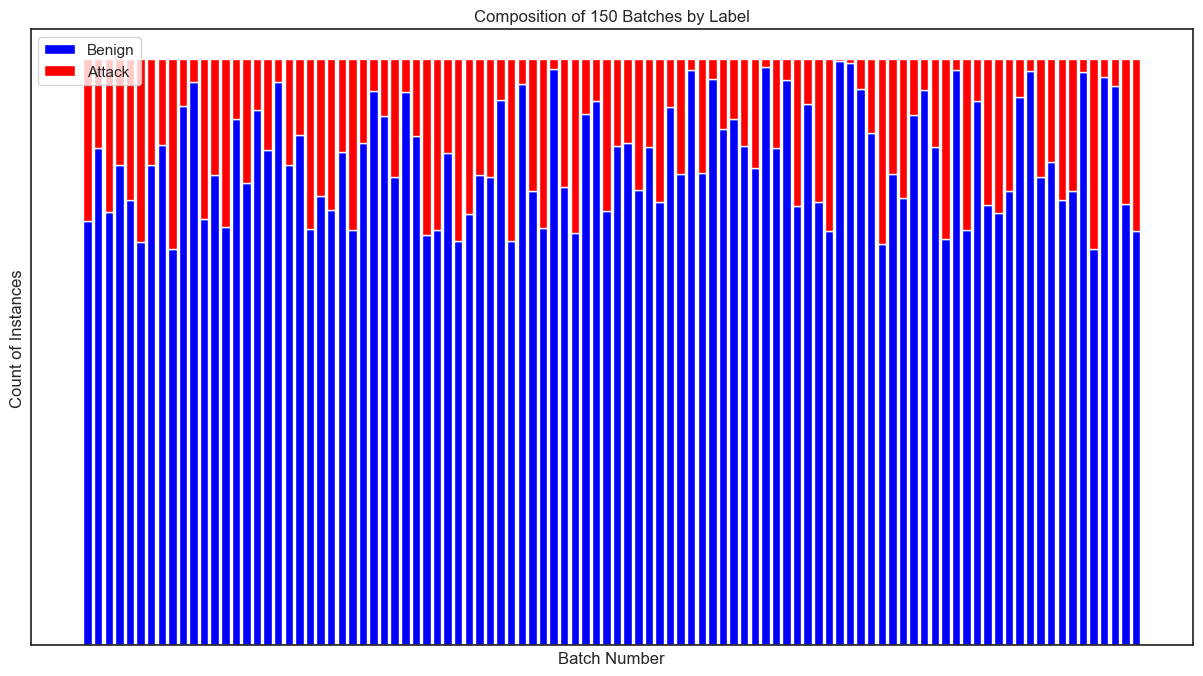

In [65]:
# Assuming 'batches' is your list of DataFrames and 'Label' is your column name
benign_counts = [batch[batch['Label'] == 0].shape[0] for batch in batches]
attack_counts = [batch[batch['Label'] == 1].shape[0] for batch in batches]
plt.figure(figsize=(15, 8))
x_axis = np.arange(1, len(benign_counts) + 1)
# Plot
plt.bar(x_axis, benign_counts, label='Benign', color='blue')
plt.bar(x_axis, attack_counts, bottom=benign_counts, label='Attack', color='red')

# Add tiltes and labels
plt.xlabel('Batch Number')
plt.ylabel('Count of Instances')
plt.title('Composition of 150 Batches by Label')
plt.xticks([])
plt.yticks([])
plt.legend()

save_path = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Save Plots\sample_150_distribution_of_instances_1.png'
plt.savefig(save_path)

plt.show()

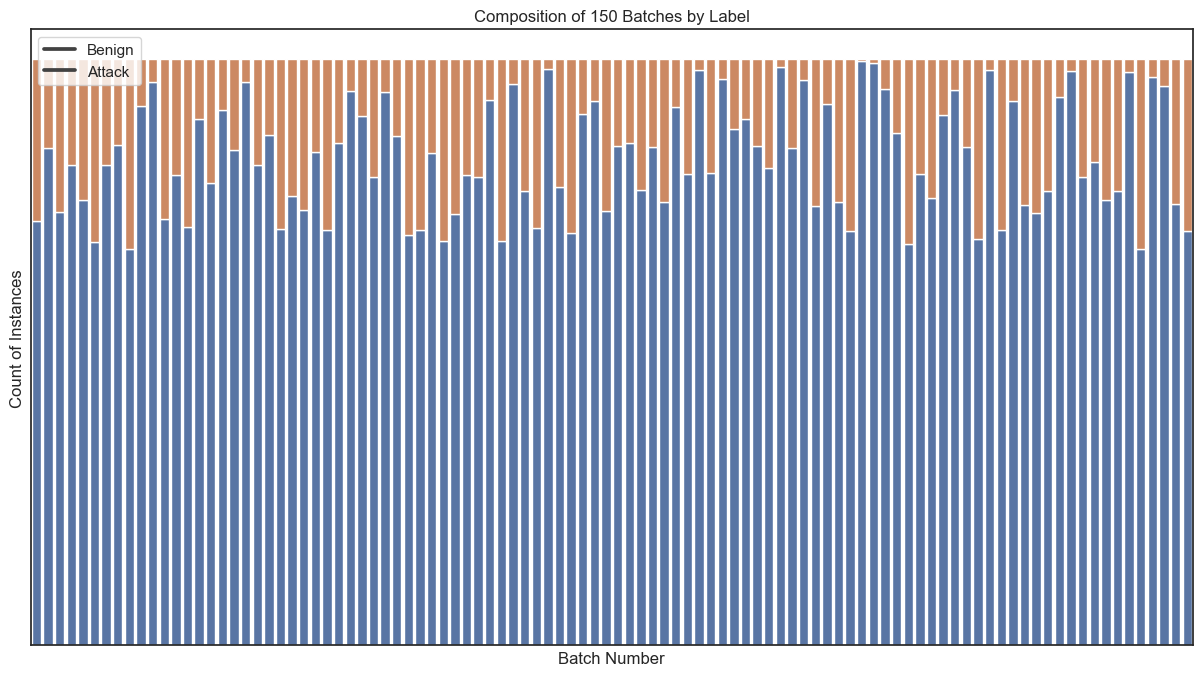

In [66]:
benign_counts = [batch[batch['Label'] == 0].shape[0] for batch in batches]
attack_counts = [batch[batch['Label'] == 1].shape[0] for batch in batches]
data = pd.DataFrame({
    'Batch Number': np.arange(len(benign_counts)),
    'Benign': benign_counts,
    'Attack': attack_counts
})
data['Attack Bottom'] = data['Benign']
melted_data = pd.melt(data, id_vars='Batch Number', value_vars=['Benign', 'Attack'],
                      var_name='Type', value_name='Count')
#sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 8))

sns.barplot(x='Batch Number', y='Count', data=melted_data[melted_data['Type'] == 'Benign'], color='#4c72b0')
sns.barplot(x='Batch Number', y='Count', data=melted_data[melted_data['Type'] == 'Attack'], color='#dd8452', bottom=data['Attack Bottom'])

plt.xlabel('Batch Number')
plt.ylabel('Count of Instances')
plt.title('Composition of 150 Batches by Label')
plt.xticks([])
plt.yticks([])
plt.legend(labels=['Benign', 'Attack'])

# save_path = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Save Plots\sample_150_distribution_of_instances_2.png'
# plt.savefig(save_path)

plt.show()

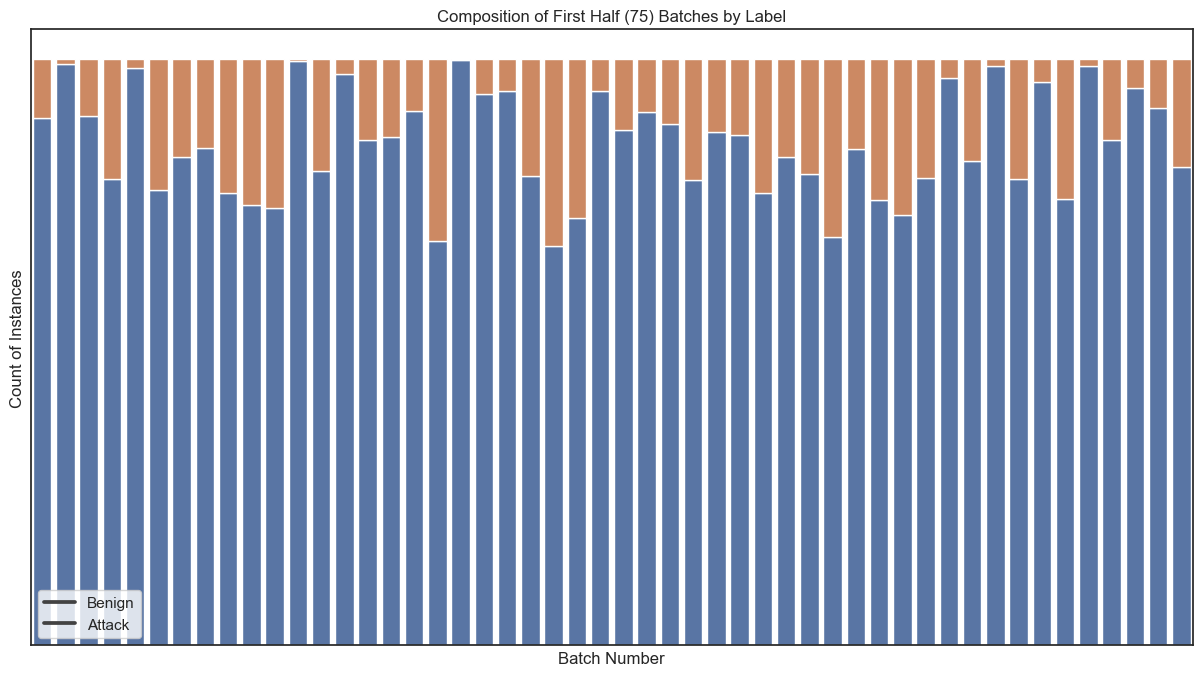

In [18]:
# # Original data preparation
# benign_counts = [batch[batch['Label'] == 0].shape[0] for batch in batches]
# attack_counts = [batch[batch['Label'] == 1].shape[0] for batch in batches]
# data = pd.DataFrame({
#     'Batch Number': np.arange(len(benign_counts)),
#     'Benign': benign_counts,
#     'Attack': attack_counts
# })

# # Selecting first half of the batches
# half_batches = int(len(benign_counts) / 2)
# data_half = data.iloc[:half_batches]

# # Adjusting for stacked bar plot
# data_half['Attack Bottom'] = data_half['Benign']
# melted_data_half = pd.melt(data_half, id_vars='Batch Number', value_vars=['Benign', 'Attack'],
#                            var_name='Type', value_name='Count')

# # Plotting
# plt.figure(figsize=(15, 8))
# sns.barplot(x='Batch Number', y='Count', data=melted_data_half[melted_data_half['Type'] == 'Benign'], color='#4c72b0')
# sns.barplot(x='Batch Number', y='Count', data=melted_data_half[melted_data_half['Type'] == 'Attack'], color='#dd8452', bottom=data_half['Attack Bottom'])

# plt.xlabel('Batch Number')
# plt.ylabel('Count of Instances')
# plt.title('Composition of First Half (75) Batches by Label')
# plt.xticks([])
# plt.yticks([])
# plt.legend(labels=['Benign', 'Attack'])

# save_path = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Save Plots\sample_75_distribution_of_instances.png'
# plt.savefig(save_path)
# plt.show()


##### View a batch

In [17]:
# pd.set_option('display.float_format', '{:.10f}'.format)
# first_row = batches[0].iloc[0]

# first_eight_values = first_row[:8]
# print(first_eight_values)

## Load Schemas

In [67]:
# Load schemas so that the batches can be converted to avro objects.

# function to load schemas
def load_avro_schema_with_fastavro(schema_file_folder):
    schema = fastavro.schema.load_schema(schema_file_folder)
    return schema

# schema files folder
schema_files_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Avro Schema'

# Schema files names
features_avro_schema_file = "features_avro_schema.avsc"
label_avro_schema_file = "label_avro_schema.avsc"

# Load the schemas
features_avro_schema = load_avro_schema_with_fastavro(os.path.join(schema_files_folder,features_avro_schema_file)) 
label_avro_schema =  load_avro_schema_with_fastavro(os.path.join(schema_files_folder, label_avro_schema_file)) 

## Convert first 5 batches to avro and save 

In [18]:
# # List to store first 5 batches #### use these as a test
# first_5_batches = batches[:5]

# # Location to store batches saved as avro files.
# output_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Producer Data\Avro Batches sample 10 250 batches'

# # Create the directory if it does not exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Loop though the fist 5 batches and convert to avro object types
# for i, batch in enumerate(first_5_batches):
    
#      # Convert the features to an Avro file.
#     features_avro_data = features_to_avro(batch, features_avro_schema)
#     features_avro_filename = os.path.join(output_folder, f"features_batch_{i}.avro")
#     with open(features_avro_filename, 'wb') as feature_file:  # Use the correct filename variable
#         feature_file.write(features_avro_data)
        
#     # Convert the label to an Avro file.
#     label_avro_data = label_to_avro(batch, label_avro_schema)
#     label_avro_filename = os.path.join(output_folder, f"label_batch_{i}.avro")
#     with open(label_avro_filename, 'wb') as label_file:  # Use the correct filename variable
#         label_file.write(label_avro_data)
        
#     print(f"Batch {i} converted into Avro format and saved to folder.")

Done. Successfully Created.

Less than 1Mb. Finally have a starting point for the producer

## Convert first 100 batches to avro and save 

In [106]:
# # List to store first 500 batches #### use these as a test
# first_100_batches = batches[:100]

# # Location to store batches saved as avro files.
# output_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Producer Data\Avro Batches sample 10 250 batches 100 avro files'

# # Create the directory if it does not exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Loop though the fist 100 batches and convert to avro object types
# for i, batch in enumerate(first_100_batches):
    
#      # Convert the features to an Avro file.
#     features_avro_data = features_to_avro(batch, features_avro_schema)
#     features_avro_filename = os.path.join(output_folder, f"features_batch_{i}.avro")
#     with open(features_avro_filename, 'wb') as feature_file:  # Use the correct filename variable
#         feature_file.write(features_avro_data)
        
#     # Convert the label to an Avro file.
#     label_avro_data = label_to_avro(batch, label_avro_schema)
#     label_avro_filename = os.path.join(output_folder, f"label_batch_{i}.avro")
#     with open(label_avro_filename, 'wb') as label_file:  # Use the correct filename variable
#         label_file.write(label_avro_data)
        
#     print(f"Batch {i} converted into Avro format and saved to folder.")

100 Batches sucessfully serialised into AVRO file and saved.

Done. Successfully Created.

## Convert first 250 batches to avro and save 

In [105]:
# # List to store first 250 batches #### use these as a test
# first_250_batches = batches[:250]

# # Location to store batches saved as avro files.
# output_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Producer Data\Avro Batches sample 10 250 batches 250 avro files'

# # Create the directory if it does not exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Loop though the fist 250 batches and convert to avro object types
# for i, batch in enumerate(first_250_batches):
    
#      # Convert the features to an Avro file.
#     features_avro_data = features_to_avro(batch, features_avro_schema)
#     features_avro_filename = os.path.join(output_folder, f"features_batch_{i}.avro")
#     with open(features_avro_filename, 'wb') as feature_file:  # Use the correct filename variable
#         feature_file.write(features_avro_data)
        
#     # Convert the label to an Avro file.
#     label_avro_data = label_to_avro(batch, label_avro_schema)
#     label_avro_filename = os.path.join(output_folder, f"label_batch_{i}.avro")
#     with open(label_avro_filename, 'wb') as label_file:  # Use the correct filename variable
#         label_file.write(label_avro_data)
        
#     print(f"Batch {i} converted into Avro format and saved to folder.")

Done. Successful.

---

# Producer

## Start Producer Connection

In [39]:
# set up the producer
producer_config = {
    'bootstrap.servers': 'localhost:9092',
    'client.id': 'jupyter-producer'
}

# Create a Kafka producer instance
producer = Producer(producer_config)

# Define a delivery report callback function
def delivery_report(err, msg):
    if err is not None:
        print('Message delivery failed: {}'.format(err))
    else:
        print('Message delivered to {} [{}]'.format(msg.topic(), msg.partition()))

## Producer: Send 5 Batches. 

In [ ]:
# save_path = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Save Plots\sample_150_distribution_of_instances_2.png'
# plt.savefig(save_path)

Done. Sucessfully Sent.


## Producer: Send 100 Batches

In [ ]:
# Send 100 batches

avro_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Producer Data\Avro Batches sample 10 250 batches 100 avro files'
    
for batch_number in range(100):
    feature_avro_filename = os.path.join(avro_folder, f"features_batch_{batch_number}.avro")
    label_avro_filename = os.path.join(avro_folder, f"label_batch_{batch_number}.avro")
    
    # read in files
    with open(feature_avro_filename, "rb") as feature_file:
        features_data = feature_file.read()
    with open(label_avro_filename, "rb") as label_file:
        label_data = label_file.read()
    
    try:
        producer.produce("batch-network-data", key=str(batch_number), value=features_data, callback=delivery_report)
        producer.produce("test-batch-labels", key=str(batch_number), value=label_data, callback=delivery_report)
    
        # Wait for the message to be delivered
        producer.flush()
        print(f"Flushed Batch {batch_number}. Waiting for callback....")

    except Exception as e:
        # Print error message if sending fails
        print(f"Error sending Batch {batch_number}: {e}")
    
    # Wait 10 seconds and send
    time.sleep(10)

Done. Successfuly Saved.

## Producer: Send 250 Batches

In [30]:
# # Send 250 batches

# avro_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Producer Data\Avro Batches sample 10 250 batches 250 avro files'
    
# for batch_number in range(250):
#     feature_avro_filename = os.path.join(avro_folder, f"features_batch_{batch_number}.avro")
#     label_avro_filename = os.path.join(avro_folder, f"label_batch_{batch_number}.avro")
    
#     # read in files
#     with open(feature_avro_filename, "rb") as feature_file:
#         features_data = feature_file.read()
#     with open(label_avro_filename, "rb") as label_file:
#         label_data = label_file.read()
    
#     try:
#         producer.produce("batch-network-data", key=str(batch_number), value=features_data, callback=delivery_report)
#         producer.produce("test-batch-labels", key=str(batch_number), value=label_data, callback=delivery_report)
    
#         # Wait for the message to be delivered
#         producer.flush()
#         print(f"Flushed Batch {batch_number}. Waiting for callback....")

#     except Exception as e:
#         # Print error message if sending fails
#         print(f"Error sending Batch {batch_number}: {e}")
    
#     # Wait 10 seconds and send
#     time.sleep(10)

Done. Successful.

---

# **Full Data - Create 1800 batches**

### Attempt 1

In [50]:
data.shape

(100, 4)

In [51]:
total_rows = len(data)
print("Total number of rows in the batch sample:", total_rows)

Total number of rows in the batch sample: 100


In [52]:
from sklearn.model_selection import train_test_split

# Create the benign and the attack instance data
benign_data = data[data['Label'] == 0]
attack_data = data[data['Label'] == 1]

# Set the number of bactches and sizes.
num_batches = 2500
batch_size = 3227 # 8 million divided by 2500, gives this. Might work.

# Create batches
def create_batches(attack_data, benign_data, num_batches, batch_size):
    batches = []
    attack_distribution = np.random.randint(0, batch_size + 1, size=num_batches)

    for num_attack in attack_distribution:
        if len(attack_data) >= num_attack:
            attack_sample = attack_data.sample(n=num_attack)
            attack_data = attack_data.drop(attack_sample.index)
        else:
            attack_sample = attack_data
            attack_data = pd.DataFrame()

        num_benign = batch_size - len(attack_sample)

        if len(benign_data) >= num_benign:
            benign_sample = benign_data.sample(n=num_benign)
            benign_data = benign_data.drop(benign_sample.index)
        else:
            benign_sample = benign_data
            benign_data = pd.DataFrame()

        batch = pd.concat([attack_sample, benign_sample]).sample(frac=1).reset_index(drop=True)
        batches.append(batch)

    # Distribute remaining data
    remaining_data = pd.concat([attack_data, benign_data])
    remaining_batches = num_batches - len(batches)
    while not remaining_data.empty and remaining_batches > 0:
        batch_size_adjusted = len(remaining_data) // remaining_batches
        batch_sample = remaining_data.sample(n=batch_size_adjusted)
        remaining_data = remaining_data.drop(batch_sample.index)
        batches.append(batch_sample.sample(frac=1).reset_index(drop=True))
        remaining_batches -= 1

    return batches

# Create batches
batches = create_batches(attack_data, benign_data, num_batches, batch_size)

KeyError: 'Label'

In [113]:
non_zero_batches = [batch for batch in batches if len(batch)>0]

In [118]:
len(non_zero_batches)

1606

In [137]:
type(non_zero_batches[0])

pandas.core.frame.DataFrame

In [127]:
total_attack_instances = sum(batch[batch["Label"]==1].shape[0] for batch in non_zero_batches)
total_attack_instances

730177

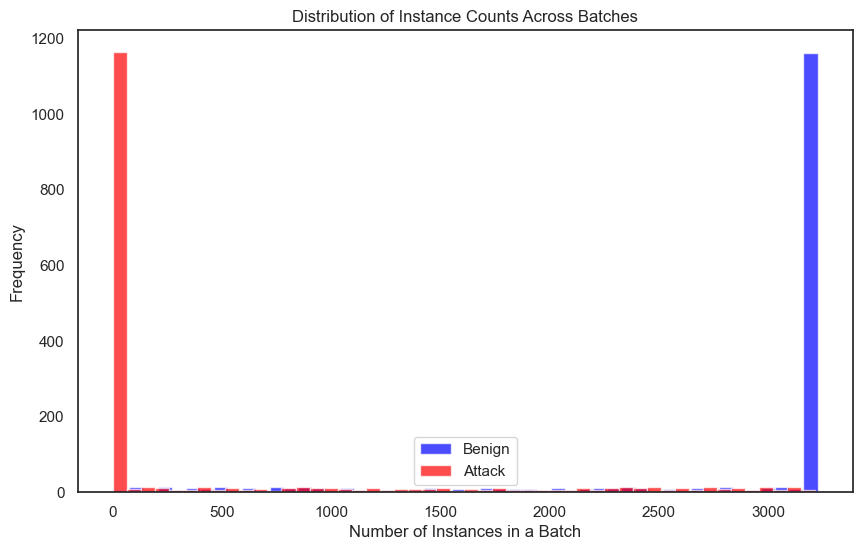

In [140]:
# Create a histrogram
plt.figure(figsize=(10, 6))
plt.hist(benign_counts, bins=50, color='blue', alpha=0.7, label='Benign')

# Histogram of attack instances counts
plt.hist(attack_counts, bins=50, color='red', alpha=0.7, label='Attack')

# show plot
plt.xlabel('Number of Instances in a Batch')
plt.ylabel('Frequency')
plt.title('Distribution of Instance Counts Across Batches')
plt.legend()
plt.show()

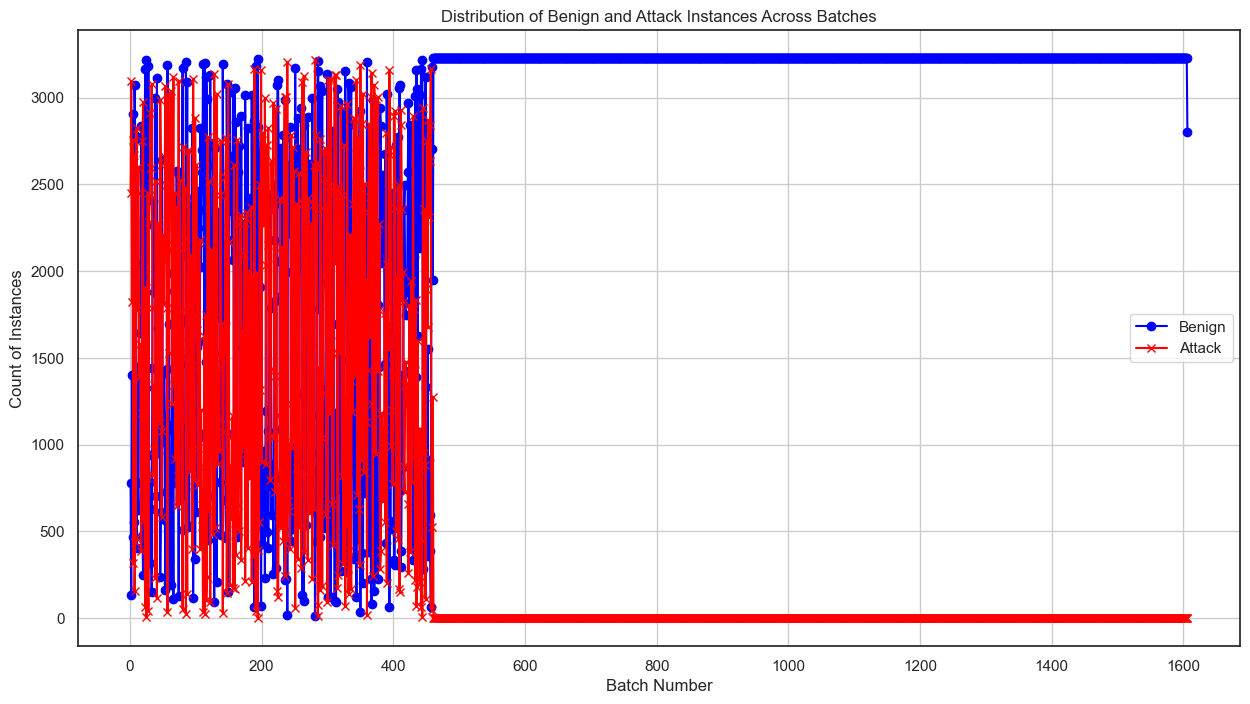

In [141]:
# Set up the figure size
plt.figure(figsize=(15, 8))

# X-axis values - batch numbers
x_axis = list(range(1, len(benign_counts) + 1))

# Plot benign counts
plt.plot(x_axis, benign_counts, label='Benign', color='blue', marker='o')

# Plot attack counts
plt.plot(x_axis, attack_counts, label='Attack', color='red', marker='x')

# Adding labels and title
plt.xlabel('Batch Number')
plt.ylabel('Count of Instances')
plt.title('Distribution of Benign and Attack Instances Across Batches')
plt.legend()

# Optional: Set x-axis limits if you want to focus on a particular range
# plt.xlim(1, 150)

# Display grid for better readability
plt.grid(True)

# Display the plot
plt.show()

Big Issue.. No attack instances after about 450 batches.

### Atttempt 2

Iterate though the batches inputing different amounts of attack instances until all the attack instances are ued up.

In [69]:
def create_batches(attack_data, benign_data, num_batches, batch_size):
    batches = []
    # Shuffle the data
    attack_data = attack_data.sample(frac=1).reset_index(drop=True)
    
    # Assign at least one attack to each batch until there are no more attacks left or each batch has one
    min_attacks_per_batch = min(len(attack_data), num_batches)
    attack_distribution = [1]*min_attacks_per_batch + [0]*(num_batches - min_attacks_per_batch)
    np.random.shuffle(attack_distribution)
    
    # Randomly distribute the remaining attack instances
    remaining_attacks = len(attack_data) - min_attacks_per_batch
    while remaining_attacks > 0:
        for i in range(num_batches):
            if remaining_attacks > 0 and attack_distribution[i] < batch_size:
                attack_distribution[i] += 1
                remaining_attacks -= 1
    
    # Track the current index of attack instances used
    current_attack_idx = 0
    
    # Now, we create the batches
     # Now, we create the batches
    for num_attack in attack_distribution:
        # Get the attack instances for this batch
        attack_sample = attack_data.iloc[current_attack_idx:current_attack_idx + num_attack]
        current_attack_idx += num_attack
    
        # Calculate how many benign instances we need
        num_benign_needed = batch_size - num_attack
        if not benign_data.empty and num_benign_needed > 0:
            # When benign_data runs out, stop sampling from it
            benign_sample = benign_data.sample(n=num_benign_needed, replace=True)
        else:
            benign_sample = pd.DataFrame()
    
        # Create the batch and shuffle
        batch = pd.concat([attack_sample, benign_sample]).sample(frac=1).reset_index(drop=True)
        batches.append(batch)

    return batches


In [70]:
# Create the benign and the attack instance data
benign_data = data[data['Label'] == 0]
attack_data = data[data['Label'] == 1]

# Set the number of bactches and sizes.
num_batches = 2500
batch_size = 3227 # 8 million divided by 2500, gives this. Might work.

KeyError: 'Label'

In [71]:
# Call the function and create batches
batches = create_batches(attack_data, benign_data, num_batches, batch_size)

NameError: name 'num_batches' is not defined

In [72]:
len(batches)

100

In [73]:
for i, row_count in enumerate(rows_per_batch, start=1):
    print(f"Batch {i} has {row_count} rows.")

NameError: name 'rows_per_batch' is not defined

In [74]:
# This will hold the count of attack instances in each batch
attack_counts_per_batch = []

# Iterate over each batch and count the attack instances
for batch in batches:
    attack_count = (batch['Label'] == 1).sum()
    attack_counts_per_batch.append(attack_count)

# Display the attack counts for the first few batches to check the distribution
for i, count in enumerate(attack_counts_per_batch[:5]):
    print(f"Batch {i+1} has {count} attack instances.")

Batch 1 has 2226 attack instances.
Batch 2 has 1225 attack instances.
Batch 3 has 2111 attack instances.
Batch 4 has 1466 attack instances.
Batch 5 has 1939 attack instances.


In [162]:
attack_counts_per_batch

[550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550,
 550

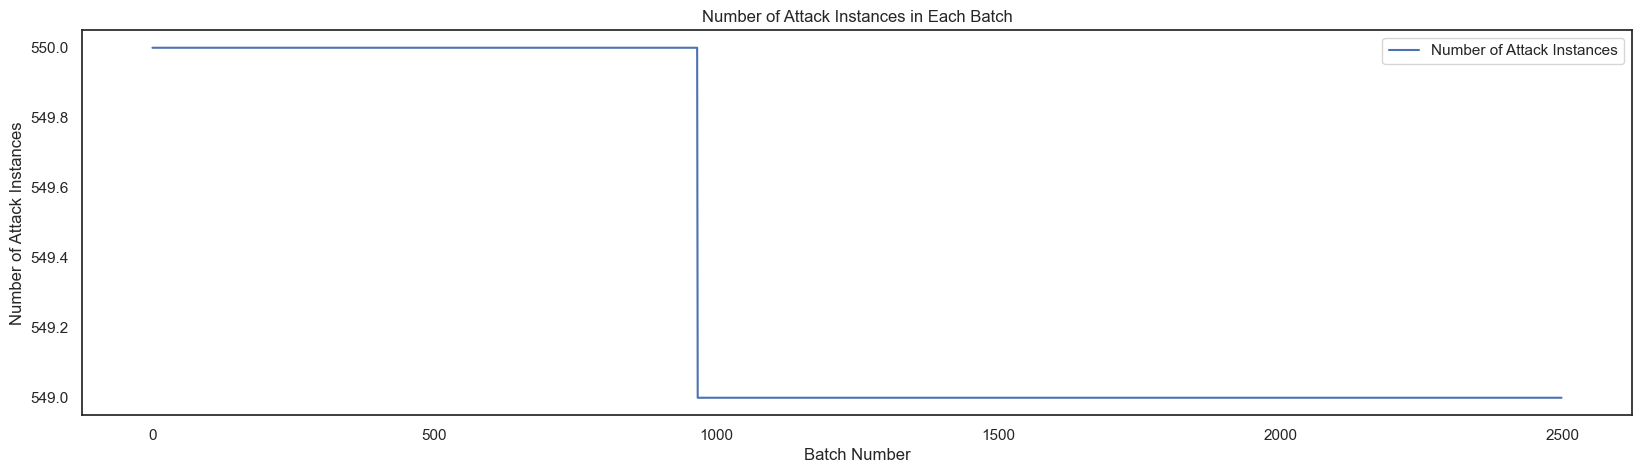

In [160]:
import matplotlib.pyplot as plt

# Plot the number of attack instances in each batch
plt.figure(figsize=(20, 5))
plt.plot(attack_counts_per_batch, label='Number of Attack Instances')
plt.xlabel('Batch Number')
plt.ylabel('Number of Attack Instances')
plt.title('Number of Attack Instances in Each Batch')
plt.legend()
plt.show()

### Attempt 3

In [75]:
def create_batches(attack_data, benign_data, num_batches, batch_size):
    batches = []
    # Shuffle the data
    attack_data = attack_data.sample(frac=1).reset_index(drop=True)
    
    # Start by assigning one attack to each batch to ensure distribution across all batches
    min_attacks_per_batch = 1
    attack_distribution = [min_attacks_per_batch] * num_batches
    
    # Randomly distribute the remaining attack instances
    remaining_attacks = len(attack_data) - num_batches
    
    # Distribute remaining attacks randomly across batches
    for _ in range(remaining_attacks):
        selected_batch = np.random.randint(0, num_batches)
        # Make sure we do not exceed batch_size
        if attack_distribution[selected_batch] < batch_size:
            attack_distribution[selected_batch] += 1
    
    np.random.shuffle(attack_distribution)  # Shuffle to randomize the distribution
    
    current_attack_idx = 0
    for num_attack in attack_distribution:
        if num_attack > 0:
            attack_sample = attack_data.iloc[current_attack_idx:current_attack_idx + num_attack]
            current_attack_idx += num_attack
        else:
            attack_sample = pd.DataFrame()
        
        num_benign_needed = batch_size - num_attack
        if num_benign_needed > len(benign_data):
            num_benign_needed = len(benign_data)  # Take only as many as we have left
        
        if num_benign_needed > 0:
            benign_sample = benign_data.sample(n=num_benign_needed, replace=False)
            benign_data = benign_data.drop(benign_sample.index).reset_index(drop=True)
        else:
            benign_sample = pd.DataFrame()
        
        batch = pd.concat([attack_sample, benign_sample]).sample(frac=1).reset_index(drop=True)
        batches.append(batch)
    
    return batches

In [48]:
# Create the benign and the attack instance data
benign_data = data[data['Label'] == 0]
attack_data = data[data['Label'] == 1]

# Set the number of bactches and sizes.
num_batches = 2500
batch_size = 3227 # 8 million divided by 2500, give this. Might work.

KeyError: 'Label'

In [22]:
# Call the function and create batches
batches = create_batches(attack_data, benign_data, num_batches, batch_size)

NameError: name 'num_batches' is not defined

In [43]:
len(batches)

100

In [41]:
# This will hold the count of attack instances in each batch
attack_counts_per_batch = []

# Iterate over each batch and count the attack instances
for batch in batches:
    attack_count = (batch['Label'] == 1).sum()
    attack_counts_per_batch.append(attack_count)

# Display the attack counts for the first few batches to check the distribution
for i, count in enumerate(attack_counts_per_batch[:5]):
    print(f"Batch {i+1} has {count} attack instances.")

Batch 1 has 790 attack instances.
Batch 2 has 863 attack instances.
Batch 3 has 561 attack instances.
Batch 4 has 2293 attack instances.
Batch 5 has 587 attack instances.


##### Use this in report

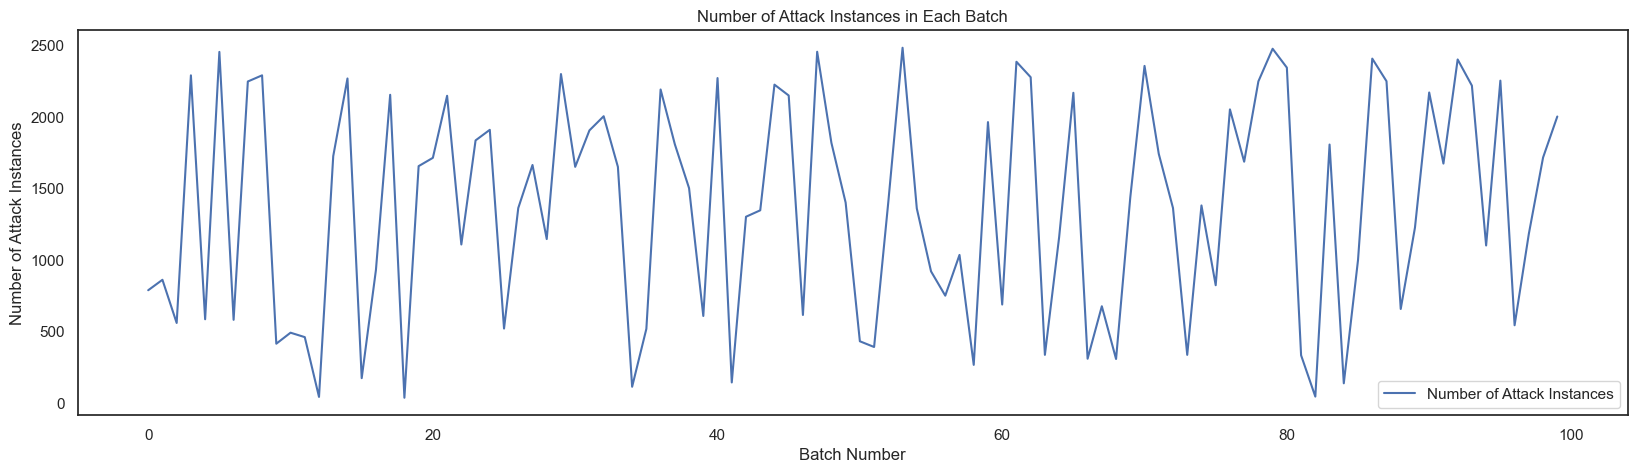

In [42]:
# Plot the number of attack instances across the batches
plt.figure(figsize=(20, 5))
plt.plot(attack_counts_per_batch, label='Number of Attack Instances')
plt.xlabel('Batch Number')
plt.ylabel('Number of Attack Instances')
plt.title('Number of Attack Instances in Each Batch')
plt.legend()
plt.show()

## 2500 batches: Convert to avro and save

In [174]:

full_data_2500_batches = batches[:2500]

# Location to store batches saved as avro files.
output_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Producer Data\Avro Batches 2500 avro files'

# Create the directory if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

start_time = time.time()
    
# Loop though the fist 250 batches and convert to avro object types
for i, batch in enumerate(full_data_2500_batches):
    
     # Convert the features to an Avro file.
    features_avro_data = features_to_avro(batch, features_avro_schema)
    features_avro_filename = os.path.join(output_folder, f"features_batch_{i}.avro")
    with open(features_avro_filename, 'wb') as feature_file:  # Use the correct filename variable
        feature_file.write(features_avro_data)
        
    # Convert the label to an Avro file.
    label_avro_data = label_to_avro(batch, label_avro_schema)
    label_avro_filename = os.path.join(output_folder, f"label_batch_{i}.avro")
    with open(label_avro_filename, 'wb') as label_file:  # Use the correct filename variable
        label_file.write(label_avro_data)
        
    print(f"Batch {i} converted into Avro format and saved to folder.")
    
end_time = time.time()
working_time = end_time - start_time
working_time

Batch 0 converted into Avro format and saved to folder.
Batch 1 converted into Avro format and saved to folder.
Batch 2 converted into Avro format and saved to folder.
Batch 3 converted into Avro format and saved to folder.
Batch 4 converted into Avro format and saved to folder.
Batch 5 converted into Avro format and saved to folder.
Batch 6 converted into Avro format and saved to folder.
Batch 7 converted into Avro format and saved to folder.
Batch 8 converted into Avro format and saved to folder.
Batch 9 converted into Avro format and saved to folder.
Batch 10 converted into Avro format and saved to folder.
Batch 11 converted into Avro format and saved to folder.
Batch 12 converted into Avro format and saved to folder.
Batch 13 converted into Avro format and saved to folder.
Batch 14 converted into Avro format and saved to folder.
Batch 15 converted into Avro format and saved to folder.
Batch 16 converted into Avro format and saved to folder.
Batch 17 converted into Avro format and s

Batch 144 converted into Avro format and saved to folder.
Batch 145 converted into Avro format and saved to folder.
Batch 146 converted into Avro format and saved to folder.
Batch 147 converted into Avro format and saved to folder.
Batch 148 converted into Avro format and saved to folder.
Batch 149 converted into Avro format and saved to folder.
Batch 150 converted into Avro format and saved to folder.
Batch 151 converted into Avro format and saved to folder.
Batch 152 converted into Avro format and saved to folder.
Batch 153 converted into Avro format and saved to folder.
Batch 154 converted into Avro format and saved to folder.
Batch 155 converted into Avro format and saved to folder.
Batch 156 converted into Avro format and saved to folder.
Batch 157 converted into Avro format and saved to folder.
Batch 158 converted into Avro format and saved to folder.
Batch 159 converted into Avro format and saved to folder.
Batch 160 converted into Avro format and saved to folder.
Batch 161 conv

Batch 286 converted into Avro format and saved to folder.
Batch 287 converted into Avro format and saved to folder.
Batch 288 converted into Avro format and saved to folder.
Batch 289 converted into Avro format and saved to folder.
Batch 290 converted into Avro format and saved to folder.
Batch 291 converted into Avro format and saved to folder.
Batch 292 converted into Avro format and saved to folder.
Batch 293 converted into Avro format and saved to folder.
Batch 294 converted into Avro format and saved to folder.
Batch 295 converted into Avro format and saved to folder.
Batch 296 converted into Avro format and saved to folder.
Batch 297 converted into Avro format and saved to folder.
Batch 298 converted into Avro format and saved to folder.
Batch 299 converted into Avro format and saved to folder.
Batch 300 converted into Avro format and saved to folder.
Batch 301 converted into Avro format and saved to folder.
Batch 302 converted into Avro format and saved to folder.
Batch 303 conv

Batch 428 converted into Avro format and saved to folder.
Batch 429 converted into Avro format and saved to folder.
Batch 430 converted into Avro format and saved to folder.
Batch 431 converted into Avro format and saved to folder.
Batch 432 converted into Avro format and saved to folder.
Batch 433 converted into Avro format and saved to folder.
Batch 434 converted into Avro format and saved to folder.
Batch 435 converted into Avro format and saved to folder.
Batch 436 converted into Avro format and saved to folder.
Batch 437 converted into Avro format and saved to folder.
Batch 438 converted into Avro format and saved to folder.
Batch 439 converted into Avro format and saved to folder.
Batch 440 converted into Avro format and saved to folder.
Batch 441 converted into Avro format and saved to folder.
Batch 442 converted into Avro format and saved to folder.
Batch 443 converted into Avro format and saved to folder.
Batch 444 converted into Avro format and saved to folder.
Batch 445 conv

Batch 570 converted into Avro format and saved to folder.
Batch 571 converted into Avro format and saved to folder.
Batch 572 converted into Avro format and saved to folder.
Batch 573 converted into Avro format and saved to folder.
Batch 574 converted into Avro format and saved to folder.
Batch 575 converted into Avro format and saved to folder.
Batch 576 converted into Avro format and saved to folder.
Batch 577 converted into Avro format and saved to folder.
Batch 578 converted into Avro format and saved to folder.
Batch 579 converted into Avro format and saved to folder.
Batch 580 converted into Avro format and saved to folder.
Batch 581 converted into Avro format and saved to folder.
Batch 582 converted into Avro format and saved to folder.
Batch 583 converted into Avro format and saved to folder.
Batch 584 converted into Avro format and saved to folder.
Batch 585 converted into Avro format and saved to folder.
Batch 586 converted into Avro format and saved to folder.
Batch 587 conv

Batch 712 converted into Avro format and saved to folder.
Batch 713 converted into Avro format and saved to folder.
Batch 714 converted into Avro format and saved to folder.
Batch 715 converted into Avro format and saved to folder.
Batch 716 converted into Avro format and saved to folder.
Batch 717 converted into Avro format and saved to folder.
Batch 718 converted into Avro format and saved to folder.
Batch 719 converted into Avro format and saved to folder.
Batch 720 converted into Avro format and saved to folder.
Batch 721 converted into Avro format and saved to folder.
Batch 722 converted into Avro format and saved to folder.
Batch 723 converted into Avro format and saved to folder.
Batch 724 converted into Avro format and saved to folder.
Batch 725 converted into Avro format and saved to folder.
Batch 726 converted into Avro format and saved to folder.
Batch 727 converted into Avro format and saved to folder.
Batch 728 converted into Avro format and saved to folder.
Batch 729 conv

Batch 854 converted into Avro format and saved to folder.
Batch 855 converted into Avro format and saved to folder.
Batch 856 converted into Avro format and saved to folder.
Batch 857 converted into Avro format and saved to folder.
Batch 858 converted into Avro format and saved to folder.
Batch 859 converted into Avro format and saved to folder.
Batch 860 converted into Avro format and saved to folder.
Batch 861 converted into Avro format and saved to folder.
Batch 862 converted into Avro format and saved to folder.
Batch 863 converted into Avro format and saved to folder.
Batch 864 converted into Avro format and saved to folder.
Batch 865 converted into Avro format and saved to folder.
Batch 866 converted into Avro format and saved to folder.
Batch 867 converted into Avro format and saved to folder.
Batch 868 converted into Avro format and saved to folder.
Batch 869 converted into Avro format and saved to folder.
Batch 870 converted into Avro format and saved to folder.
Batch 871 conv

Batch 996 converted into Avro format and saved to folder.
Batch 997 converted into Avro format and saved to folder.
Batch 998 converted into Avro format and saved to folder.
Batch 999 converted into Avro format and saved to folder.
Batch 1000 converted into Avro format and saved to folder.
Batch 1001 converted into Avro format and saved to folder.
Batch 1002 converted into Avro format and saved to folder.
Batch 1003 converted into Avro format and saved to folder.
Batch 1004 converted into Avro format and saved to folder.
Batch 1005 converted into Avro format and saved to folder.
Batch 1006 converted into Avro format and saved to folder.
Batch 1007 converted into Avro format and saved to folder.
Batch 1008 converted into Avro format and saved to folder.
Batch 1009 converted into Avro format and saved to folder.
Batch 1010 converted into Avro format and saved to folder.
Batch 1011 converted into Avro format and saved to folder.
Batch 1012 converted into Avro format and saved to folder.
B

Batch 1135 converted into Avro format and saved to folder.
Batch 1136 converted into Avro format and saved to folder.
Batch 1137 converted into Avro format and saved to folder.
Batch 1138 converted into Avro format and saved to folder.
Batch 1139 converted into Avro format and saved to folder.
Batch 1140 converted into Avro format and saved to folder.
Batch 1141 converted into Avro format and saved to folder.
Batch 1142 converted into Avro format and saved to folder.
Batch 1143 converted into Avro format and saved to folder.
Batch 1144 converted into Avro format and saved to folder.
Batch 1145 converted into Avro format and saved to folder.
Batch 1146 converted into Avro format and saved to folder.
Batch 1147 converted into Avro format and saved to folder.
Batch 1148 converted into Avro format and saved to folder.
Batch 1149 converted into Avro format and saved to folder.
Batch 1150 converted into Avro format and saved to folder.
Batch 1151 converted into Avro format and saved to folde

Batch 1274 converted into Avro format and saved to folder.
Batch 1275 converted into Avro format and saved to folder.
Batch 1276 converted into Avro format and saved to folder.
Batch 1277 converted into Avro format and saved to folder.
Batch 1278 converted into Avro format and saved to folder.
Batch 1279 converted into Avro format and saved to folder.
Batch 1280 converted into Avro format and saved to folder.
Batch 1281 converted into Avro format and saved to folder.
Batch 1282 converted into Avro format and saved to folder.
Batch 1283 converted into Avro format and saved to folder.
Batch 1284 converted into Avro format and saved to folder.
Batch 1285 converted into Avro format and saved to folder.
Batch 1286 converted into Avro format and saved to folder.
Batch 1287 converted into Avro format and saved to folder.
Batch 1288 converted into Avro format and saved to folder.
Batch 1289 converted into Avro format and saved to folder.
Batch 1290 converted into Avro format and saved to folde

Batch 1413 converted into Avro format and saved to folder.
Batch 1414 converted into Avro format and saved to folder.
Batch 1415 converted into Avro format and saved to folder.
Batch 1416 converted into Avro format and saved to folder.
Batch 1417 converted into Avro format and saved to folder.
Batch 1418 converted into Avro format and saved to folder.
Batch 1419 converted into Avro format and saved to folder.
Batch 1420 converted into Avro format and saved to folder.
Batch 1421 converted into Avro format and saved to folder.
Batch 1422 converted into Avro format and saved to folder.
Batch 1423 converted into Avro format and saved to folder.
Batch 1424 converted into Avro format and saved to folder.
Batch 1425 converted into Avro format and saved to folder.
Batch 1426 converted into Avro format and saved to folder.
Batch 1427 converted into Avro format and saved to folder.
Batch 1428 converted into Avro format and saved to folder.
Batch 1429 converted into Avro format and saved to folde

Batch 1552 converted into Avro format and saved to folder.
Batch 1553 converted into Avro format and saved to folder.
Batch 1554 converted into Avro format and saved to folder.
Batch 1555 converted into Avro format and saved to folder.
Batch 1556 converted into Avro format and saved to folder.
Batch 1557 converted into Avro format and saved to folder.
Batch 1558 converted into Avro format and saved to folder.
Batch 1559 converted into Avro format and saved to folder.
Batch 1560 converted into Avro format and saved to folder.
Batch 1561 converted into Avro format and saved to folder.
Batch 1562 converted into Avro format and saved to folder.
Batch 1563 converted into Avro format and saved to folder.
Batch 1564 converted into Avro format and saved to folder.
Batch 1565 converted into Avro format and saved to folder.
Batch 1566 converted into Avro format and saved to folder.
Batch 1567 converted into Avro format and saved to folder.
Batch 1568 converted into Avro format and saved to folde

Batch 1691 converted into Avro format and saved to folder.
Batch 1692 converted into Avro format and saved to folder.
Batch 1693 converted into Avro format and saved to folder.
Batch 1694 converted into Avro format and saved to folder.
Batch 1695 converted into Avro format and saved to folder.
Batch 1696 converted into Avro format and saved to folder.
Batch 1697 converted into Avro format and saved to folder.
Batch 1698 converted into Avro format and saved to folder.
Batch 1699 converted into Avro format and saved to folder.
Batch 1700 converted into Avro format and saved to folder.
Batch 1701 converted into Avro format and saved to folder.
Batch 1702 converted into Avro format and saved to folder.
Batch 1703 converted into Avro format and saved to folder.
Batch 1704 converted into Avro format and saved to folder.
Batch 1705 converted into Avro format and saved to folder.
Batch 1706 converted into Avro format and saved to folder.
Batch 1707 converted into Avro format and saved to folde

---

# Older Code - Used for testing various options.

### Basic Producer Test

This is a quick test to connect the producer to the consumer with "network-data-events" to test if the connections are working.

In [ ]:
# # Kafka Configuration
# conf = {
#     'bootstrap.servers': 'localhost:9092', # Local kafka server
#     'client.id': 'jupyter-producer'
# }

# # Create a Producer Instance
# producer = Producer(conf)

# # Define a delivery report callback for confirmation or error of message delivery
# def delivery_report(err, msg):
#     if err is not None:
#         print(f"Message delivery failed: {err}")
#     else:
#         print(f"Message delivered to {msg.topic()} [{msg.partition()}]")
        
# # Send a message to the Consumer
# producer.produce('network-data-events', key='test-key', value='test-value', callback=delivery_report)

# # Wait for any outstanding messages to be retured or the delivery report
# producer.flush()

With the consumer not listening you get the:

Message delivered to network-data-events [0]

0

**Note:** Start the Consumer.

In [ ]:
# # Send a message to the Consumer
# producer.produce('network-data-events', key='test-key', value='Monday 13:46', callback=delivery_report)

# # Wait for any outstanding messages to be retured or the delivery report
# producer.flush()

---

### Convert the full dataset to Avro to see results

In [ ]:
# features_avro_schema=[]
# for _, row in data.iterrows():
    
#     # Create a dictionary representing the Avro record.
#     avro_record = {
#         field["name"]: float(row[field["name"]]) if field["type"] == "float" else int(row[field["name"]])
#         for field in features_avro_schema["fields"] 
#     }
#     # append the avro record to the list
#     avro_records.append(avro_record)

In [ ]:
# # Look at the size of the new avro file
# size_in_bytes_avro = len(avro_records)

# print("Size of the Avro record in butes", size_in_bytes_avro)

# avro_size_kb = size_in_bytes_avro/1024
# avro_size_mb = size_in_bytes_avro / (1024*1014)

# print("Size of Avro record: {} bytes, {} KB, {} MB". format(size_in_bytes_avro, avro_size_kb, avro_size_mb))

A huge reduction in the size of the data, from over 926MB to 7.7 Mb

---

### Explore Batches of Full data

##### 50 batches

When the 50 batches are created the amount of attack instances were randomised.

This is hard. Come back to.

In [ ]:
# # I want to randomise the batches so they have different amounts of attack data in each.

# # Shuffle the dataset
# data = data.sample(frac=1).reset_index(drop=True)

# # split the dataset into the two labels so that each batch can have a mixture.
# benign_data = data[data['Label'] == 0]
# attack_data = data[data['Label'] == 1]

# # Calculate the total number of attack instancs so we know how many to spread across the batches.
# total_attack_instances = len(attack_data)

# # Number of batches. I choose 50 for now.
# batch_size = len(data) // 50

# # Randomise the number of instances to place in each batch
# attack_distribution = np.random.randint(0, batch_size, size=50)
# # Ensure the sum does not exceed the total number of attack instances
# while sum(attack_distribution) > total_attack_instances:
#     # Scale down the distribution if the sum exceeds the total number of attack instances
#     attack_distribution = (attack_distribution / sum(attack_distribution) * total_attack_instances).astype(int)

# # Makes the batches
# batches = []
# for num_attack in attack_distribution:
#     # Sample attack instances
#     attack_sample = attack_data.sample(n=num_attack, replace=False)
#     attack_data = attack_data.drop(attack_sample.index)
    
#     # Determine the number of benign instances needed to fill the batch
#     num_benign = batch_size - num_attack
    
#     # Sample benign instances
#     benign_sample = benign_data.sample(n=num_benign, replace=False)
#     benign_data = benign_data.drop(benign_sample.index)
    
#     # Combine the attack and benign samples to form the batch
#     batch = pd.concat([attack_sample, benign_sample])
    
#     # Shuffle the batch
#     batch = batch.sample(frac=1).reset_index(drop=True)
    
#     # Add the batch to the list of batches
#     batches.append(batch)


##### Explore the batches and Visualise the batches

In [ ]:
# # Get a list of the batches - they are all the same size which is good.
# batch_sizes = [len(batch) for batch in batches]
# print(batch_sizes)

In [ ]:
# # get the number of batches to check we just have 50 batches
# number_of_batches = len(batches)
# print(f"The total number of batches is: {number_of_batches}")

In [ ]:
# # Assuming 'batches' is your list of DataFrames and 'Label' is your column name
# benign_counts = [batch[batch['Label'] == 0].shape[0] for batch in batches]
# attack_counts = [batch[batch['Label'] == 1].shape[0] for batch in batches]

# # Set up the figure size
# plt.figure(figsize=(15, 8))

# # X-axis values - batch numbers
# x_axis = np.arange(1, len(benign_counts) + 1)

# # Plot benign counts
# plt.bar(x_axis, benign_counts, label='Benign', color='blue')

# # Plot attack counts on top of benign counts
# plt.bar(x_axis, attack_counts, bottom=benign_counts, label='Attack', color='red')

# # Adding labels and title
# plt.xlabel('Batch Number')
# plt.ylabel('Count of Instances')
# plt.title('Composition of 50 Batches by Label')
# plt.xticks(x_axis)  # Set x-ticks to be the batch numbers
# plt.legend()

# # Display the plot
# plt.show()


Above here are the 50 batches with a randomise of the different attack instances. This is what the research wants to once again show a real world setting as close as possible as an even distribution would not be right.

In [ ]:
# print(f"The total number of benign instances is: {sum(benign_counts)}")
# print(f"The total number of attack instances is: {sum(attack_counts)}")
# print(f"The total number of instances is: {sum(benign_counts)+ sum(attack_counts)}")

The number is slightly less so that 50 batches can be created.

---

##### Data is too large to send.

My first attempt to send the data to the broker to the consumer resulted in issues as each batch was 249mb and this a surprise as each batch was 16mb. I learned this is beacuse the broker sends the batches in JSON which upscales them to very large files.

##### Exploring the size of data being sent

The batches are set to 16Mb but after they are transfered into JSON files they increase into 179Mb. Much too large for the Kafka Broker(or Server). Realistically this needs to be close to 1-2Mb max for the Kafka broker. So this is a big issue.

Below we explored Aparche Avro to compress the data. The full datset was compressed from over 926Mb to just over 7.7Mb. An incredible saving on data size.

In [ ]:
# # How big are the batches?
# print(len(features_str.encode('utf-8')))

In [ ]:
# # Example: Serialize one batch and measure its size in bytes
# serialized_batch = json.dumps(batches[0].to_dict())
# size_in_bytes = len(serialized_batch.encode('utf-8'))

# print("Size of the serialized batch in bytes:", size_in_bytes)
# print("Size in MB:", size_in_bytes / (1024 * 1024))

This size of data is much too large for the Broker. 

One option is Apache Avro that is a binary serialization used within the Kafka Ecosystem.

---

###  Next, Take the batches and convert these to AVRO  (5 batches for now to test)

##### Take the first 5 batches and seperate out the Features and Labels ( 5 batches for now to test)

In [ ]:
# # define empty list to store the features and labels (first 5 batches)

# batch_feature_list = []
# batch_label_list = []

# # Iterate though the first 5 batches
# for i, batch in enumerate(batches[:5]):
    
#     # Separate features and labels
#     features = batch.drop('Label', axis=1) # Features
#     label = batch["Label"] # Label
    
#     # Apend the features and the label to thir respective lists
#     batch_feature_list.append(features)
#     batch_label_list.append(labels)

In [ ]:
# # Waht does batch one feature look like:
# print("Batch 1 Features:")
# print(batch_feature_list[0])

In [ ]:
# # What does batch one label look like:
# print("Batch 1 Label:")
# print(batch_label_list[0])

##### Size of these batches

In [ ]:
# print("Batch 1 feature size:", sys.getsizeof(batch_feature_list[0]) / (1024 * 1024))

In [ ]:
# print("Batch 1 feature size:", sys.getsizeof(batch_label_list[0]) / (1024 * 1024))

---

In [ ]:
# # List to store first 5 batches #### use these as a test
# first_5_batches = batches[:5]

# # Location to store batches saved as avro files.
# output_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Avro Batches'

# # Create the directory if it does not exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Loop though the fist 5 batches and convert to avro object types
# for i, batch in enumerate(first_5_batches):
    
#      # Convert the features to an Avro file.
#     features_avro_data = features_to_avro(batch, features_avro_schema)
#     features_avro_filename = os.path.join(output_folder, f"features_batch_{i}.avro")
#     with open(features_avro_filename, 'wb') as feature_file:  # Use the correct filename variable
#         feature_file.write(features_avro_data)
        
#     # Convert the label to an Avro file.
#     label_avro_data = label_to_avro(batch, label_avro_schema)
#     label_avro_filename = os.path.join(output_folder, f"label_batch_{i}.avro")
#     with open(label_avro_filename, 'wb') as label_file:  # Use the correct filename variable
#         label_file.write(label_avro_data)
        
#     print(f"Batch {i} converted into Avro format and saved to folder.")

##### Now compress these files.

In [ ]:
# # Location to store compressed Avro files
# compressed_output_folder = os.path.join(output_folder, 'Compressed')
# if not os.path.exists(compressed_output_folder):
#     os.makedirs(compressed_output_folder)

# # Loop through the first 5 batches to compress the Avro files
# for i in range(5):
#     # File paths for the existing uncompressed Avro files
#     features_avro_filename = os.path.join(output_folder, f"features_batch_{i}.avro")
#     label_avro_filename = os.path.join(output_folder, f"label_batch_{i}.avro")

#     # File paths for the new compressed Avro files
#     compressed_features_filename = os.path.join(compressed_output_folder, f"features_batch_{i}.snappy")
#     compressed_label_filename = os.path.join(compressed_output_folder, f"label_batch_{i}.snappy")

#     # Compress and write the features Avro file
#     with open(features_avro_filename, 'rb') as features_file, open(compressed_features_filename, 'wb') as compressed_features_file:
#         compressed_features_file.write(snappy.compress(features_file.read()))

#     # Compress and write the label Avro file
#     with open(label_avro_filename, 'rb') as label_file, open(compressed_label_filename, 'wb') as compressed_label_file:
#         compressed_label_file.write(snappy.compress(label_file.read()))

#     print(f"Batch {i} Avro files compressed with Snappy and saved to folder.")


Batches are 40Mb. Too large for Kafka broker. Need to be around 1mb.

---

### Converted into Avro format with Snappy compression and saved to folder. NOT USED

In [ ]:
# # List to store first 5 batches #### use these as a test
# first_5_batches = batches[:5]

# # Location to store batches saved as Avro files.
# output_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Avro Batches'

# # Create the directory if it does not exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Loop through the first 5 batches and convert to Avro object types
# for i, batch in enumerate(first_5_batches):
#     # Convert the features to Avro data
#     features_avro_data = features_to_avro(batch, features_avro_schema)
    
#     # Compress the features Avro data with gzip
#     features_avro_data_compressed = gzip.compress(features_avro_data)
    
#     # Write the compressed features Avro data to a file
#     features_avro_filename = os.path.join(output_folder, f"features_batch_{i}.avro.gz")
#     with open(features_avro_filename, 'wb') as feature_file:
#         feature_file.write(features_avro_data_compressed)
        
#     # Convert the label to Avro data
#     label_avro_data = label_to_avro(batch, label_avro_schema)
    
#     # Compress the label Avro data with gzip
#     label_avro_data_compressed = gzip.compress(label_avro_data)
    
#     # Write the compressed label Avro data to a file
#     label_avro_filename = os.path.join(output_folder, f"label_batch_{i}.avro.gz")
#     with open(label_avro_filename, 'wb') as label_file:
#         label_file.write(label_avro_data_compressed)
        
#     print(f"Batch {i} converted into Avro format with gzip compression and saved to folder.")


The files comrpessed this way are 20mb-ish. Still too big.

---

### 200 batches of Full Data

Explore the use of 200 batches as a test

In [ ]:

# # I want to randomise the batches so they have different amounts of attack data in each.

# # Shuffle the dataset
# data = data.sample(frac=1).reset_index(drop=True)

# # split the dataset into the two labels so that each batch can have a mixture.
# benign_data = data[data['Label'] == 0]
# attack_data = data[data['Label'] == 1]

# # Calculate the total number of attack instancs so we know how many to spread across the batches.
# total_attack_instances = len(attack_data)

# # Number of batches. I choose 200 for now.
# batch_size = len(data) // 200

# # Randomise the number of instances to place in each batch
# attack_distribution = np.random.randint(0, batch_size, size=200)
# # Ensure the sum does not exceed the total number of attack instances
# while sum(attack_distribution) > total_attack_instances:
#     # Scale down the distribution if the sum exceeds the total number of attack instances
#     attack_distribution = (attack_distribution / sum(attack_distribution) * total_attack_instances).astype(int)

# # Makes the batches
# batches = []
# for num_attack in attack_distribution:
#     # Sample attack instances
#     attack_sample = attack_data.sample(n=num_attack, replace=False)
#     attack_data = attack_data.drop(attack_sample.index)
    
#     # Determine the number of benign instances needed to fill the batch
#     num_benign = batch_size - num_attack
    
#     # Sample benign instances
#     benign_sample = benign_data.sample(n=num_benign, replace=False)
#     benign_data = benign_data.drop(benign_sample.index)
    
#     # Combine the attack and benign samples to form the batch
#     batch = pd.concat([attack_sample, benign_sample])
    
#     # Shuffle the batch
#     batch = batch.sample(frac=1).reset_index(drop=True)
    
#     # Add the batch to the list of batches
#     batches.append(batch)



##### Explore the batches and Visualise the batches

In [ ]:
# # Get a list of the batches - they are all the same size which is good.
# batch_sizes = [len(batch) for batch in batches]
# print(batch_sizes)

In [ ]:
# # get the number of batches to check we just have 50 batches
# number_of_batches = len(batches)
# print(f"The total number of batches is: {number_of_batches}")

In [ ]:
# # Assuming 'batches' is your list of DataFrames and 'Label' is your column name
# benign_counts = [batch[batch['Label'] == 0].shape[0] for batch in batches]
# attack_counts = [batch[batch['Label'] == 1].shape[0] for batch in batches]

# # Set up the figure size
# plt.figure(figsize=(15, 8))

# # X-axis values - batch numbers
# x_axis = np.arange(1, len(benign_counts) + 1)

# # Plot benign counts
# plt.bar(x_axis, benign_counts, label='Benign', color='blue')

# # Plot attack counts on top of benign counts
# plt.bar(x_axis, attack_counts, bottom=benign_counts, label='Attack', color='red')

# # Adding labels and title
# plt.xlabel('Batch Number')
# plt.ylabel('Count of Instances')
# plt.title('Composition of 200 Batches by Label')
# plt.xticks(x_axis)  # Set x-ticks to be the batch numbers
# plt.legend()

# # Display the plot
# plt.show()

In [ ]:
# print(f"The total number of benign instances is: {sum(benign_counts)}")
# print(f"The total number of attack instances is: {sum(attack_counts)}")
# print(f"The total number of instances is: {sum(benign_counts)+ sum(attack_counts)}")

### Converted into Avro format and saved to folder

In [ ]:
# # List to store first 5 batches #### use these as a test
# first_10_batches = batches[:10]

# # Location to store batches saved as avro files.
# output_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Avro Batches 200'

# # Create the directory if it does not exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Loop though the fist 5 batches and convert to avro object types
# for i, batch in enumerate(first_10_batches):
    
#      # Convert the features to an Avro file.
#     features_avro_data = features_to_avro(batch, features_avro_schema)
#     features_avro_filename = os.path.join(output_folder, f"features_batch_{i}.avro")
#     with open(features_avro_filename, 'wb') as feature_file:  # Use the correct filename variable
#         feature_file.write(features_avro_data)
        
#     # Convert the label to an Avro file.
#     label_avro_data = label_to_avro(batch, label_avro_schema)
#     label_avro_filename = os.path.join(output_folder, f"label_batch_{i}.avro")
#     with open(label_avro_filename, 'wb') as label_file:  # Use the correct filename variable
#         label_file.write(label_avro_data)
        
#     print(f"Batch {i} converted into Avro format and saved to folder.")

In [ ]:
# # Location to store compressed Avro files
# compressed_output_folder = os.path.join(output_folder, 'Compressed')
# if not os.path.exists(compressed_output_folder):
#     os.makedirs(compressed_output_folder)

# # Loop through the first 10 batches to compress the Avro files
# for i in range(10):
#     # File paths for the existing uncompressed Avro files
#     features_avro_filename = os.path.join(output_folder, f"features_batch_{i}.avro")
#     label_avro_filename = os.path.join(output_folder, f"label_batch_{i}.avro")

#     # File paths for the new compressed Avro files
#     compressed_features_filename = os.path.join(compressed_output_folder, f"features_batch_{i}.snappy")
#     compressed_label_filename = os.path.join(compressed_output_folder, f"label_batch_{i}.snappy")

#     # Compress and write the features Avro file
#     with open(features_avro_filename, 'rb') as features_file, open(compressed_features_filename, 'wb') as compressed_features_file:
#         compressed_features_file.write(snappy.compress(features_file.read()))

#     # Compress and write the label Avro file
#     with open(label_avro_filename, 'rb') as label_file, open(compressed_label_filename, 'wb') as compressed_label_file:
#         compressed_label_file.write(snappy.compress(label_file.read()))

#     print(f"Batch {i} Avro files compressed with Snappy and saved to folder.")

---

### 150 batches of sample data

In [ ]:
# # Shuffle the dataset
# final_sample = final_sample.sample(frac=1).reset_index(drop=True)

# # split the dataset into the two labels so that each batch can have a mixture.
# benign_data = final_sample[final_sample['Label'] == 0]
# attack_data = final_sample[final_sample['Label'] == 1]

# # Calculate the total number of attack instancs so we know how many to spread across the batches.
# total_attack_instances = len(attack_data)

# # Number of batches. I choose 150 for now.
# batch_size = len(final_sample) // 150

# # Randomise the number of instances to place in each batch
# attack_distribution = np.random.randint(0, batch_size, size=150)
# # Ensure the sum does not exceed the total number of attack instances
# while sum(attack_distribution) > total_attack_instances:
#     # Scale down the distribution if the sum exceeds the total number of attack instances
#     attack_distribution = (attack_distribution / sum(attack_distribution) * total_attack_instances).astype(int)

# # Makes the batches
# batches = []
# for num_attack in attack_distribution:
#     # Ensure there are enough attack instances available
#     num_attack = min(num_attack, len(attack_data))
#     attack_sample = attack_data.sample(n=num_attack, replace=False)
#     attack_data = attack_data.drop(attack_sample.index)
    
#     # Determine the number of benign instances needed to fill the batch
#     num_benign = batch_size - num_attack

#     # Ensure there are enough benign instances available
#     num_benign = min(num_benign, len(benign_data))
#     benign_sample = benign_data.sample(n=num_benign, replace=False) if num_benign > 0 else pd.DataFrame()
#     benign_data = benign_data.drop(benign_sample.index)
    
#     # Combine the attack and benign samples to form the batch
#     batch = pd.concat([attack_sample, benign_sample]).sample(frac=1).reset_index(drop=True)
#     batches.append(batch)

In [ ]:
# # get the number of batches to check we just have 150 batches
# number_of_batches = len(batches)
# print(f"The total number of batches is: {number_of_batches}")

In [ ]:
# # Get a list of the batches - they are all the same size which is good.
# batch_sizes = [len(batch) for batch in batches]
# print(batch_sizes)

In [ ]:
# # Assuming 'batches' is your list of DataFrames and 'Label' is your column name
# benign_counts = [batch[batch['Label'] == 0].shape[0] for batch in batches]
# attack_counts = [batch[batch['Label'] == 1].shape[0] for batch in batches]

# # Set up the figure size
# plt.figure(figsize=(15, 8))

# # X-axis values - batch numbers
# x_axis = np.arange(1, len(benign_counts) + 1)

# # Plot benign counts
# plt.bar(x_axis, benign_counts, label='Benign', color='blue')

# # Plot attack counts on top of benign counts
# plt.bar(x_axis, attack_counts, bottom=benign_counts, label='Attack', color='red')

# # Adding labels and title
# plt.xlabel('Batch Number')
# plt.ylabel('Count of Instances')
# plt.title('Composition of 150 Batches by Label')
# plt.xticks(x_axis)  # Set x-ticks to be the batch numbers
# plt.legend()

# # Display the plot
# plt.show()

In [ ]:
# print(f"The total number of benign instances is: {sum(benign_counts)}")
# print(f"The total number of attack instances is: {sum(attack_counts)}")
# print(f"The total number of instances is: {sum(benign_counts)+ sum(attack_counts)}")

##### Convert to Avro objects

In [ ]:
# # List to store first 5 batches #### use these as a test
# first_5_batches = batches[:5]

# # Location to store batches saved as avro files.
# output_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Avro Batches sample 10 150 batches'

# # Create the directory if it does not exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Loop though the fist 5 batches and convert to avro object types
# for i, batch in enumerate(first_5_batches):
    
#      # Convert the features to an Avro file.
#     features_avro_data = features_to_avro(batch, features_avro_schema)
#     features_avro_filename = os.path.join(output_folder, f"features_batch_{i}.avro")
#     with open(features_avro_filename, 'wb') as feature_file:  # Use the correct filename variable
#         feature_file.write(features_avro_data)
        
#     # Convert the label to an Avro file.
#     label_avro_data = label_to_avro(batch, label_avro_schema)
#     label_avro_filename = os.path.join(output_folder, f"label_batch_{i}.avro")
#     with open(label_avro_filename, 'wb') as label_file:  # Use the correct filename variable
#         label_file.write(label_avro_data)
        
#     print(f"Batch {i} converted into Avro format and saved to folder.")

1.5mb size

In [ ]:
# # Location to store compressed Avro files
# compressed_output_folder = os.path.join(output_folder, 'Compressed')
# if not os.path.exists(compressed_output_folder):
#     os.makedirs(compressed_output_folder)

# # Loop through the first 5 batches to compress the Avro files
# for i in range(5):
#     # File paths for the existing uncompressed Avro files
#     features_avro_filename = os.path.join(output_folder, f"features_batch_{i}.avro")
#     label_avro_filename = os.path.join(output_folder, f"label_batch_{i}.avro")

#     # File paths for the new compressed Avro files
#     compressed_features_filename = os.path.join(compressed_output_folder, f"features_batch_{i}.snappy")
#     compressed_label_filename = os.path.join(compressed_output_folder, f"label_batch_{i}.snappy")

#     # Compress and write the features Avro file
#     with open(features_avro_filename, 'rb') as features_file, open(compressed_features_filename, 'wb') as compressed_features_file:
#         compressed_features_file.write(snappy.compress(features_file.read()))

#     # Compress and write the label Avro file
#     with open(label_avro_filename, 'rb') as label_file, open(compressed_label_filename, 'wb') as compressed_label_file:
#         compressed_label_file.write(snappy.compress(label_file.read()))

#     print(f"Batch {i} Avro files compressed with Snappy and saved to folder.")


less than 700k. However, at this point I do not want to use compressed files. So I will train other batches.

##### Covert back out of avro to test.

In [ ]:
# # Function to deserialize Avro data from a file
# def deserialize_avro_file(avro_file_path, avro_schema):
#     with open(avro_file_path, 'rb') as file:
#         avro_reader = reader(file, avro_schema)
#         return [record for record in avro_reader]

# # Test deserialization of the first batch
# test_features_file = os.path.join(output_folder, "features_batch_0.avro")
# test_label_file = os.path.join(output_folder, "label_batch_0.avro")

# # Deserialize the data
# deserialized_features = deserialize_avro_file(test_features_file, features_avro_schema)
# deserialized_labels = deserialize_avro_file(test_label_file, label_avro_schema)

# # Print the deserialized data
# print("Deserialized Features:", deserialized_features[:5])  # print first 5 records for brevity
# print("Deserialized Labels:", deserialized_labels[:5])

 This is ok.

In [ ]:
# # save 

# # Path where you want to save the Avro file
# avro_data_file_path = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Avro Batches sample'

# # Write the Avro-encoded data to a file
# with open(avro_data_file_path, 'wb') as file:
#     file.write(features_avro_data)

# print(f"Avro data saved to: {avro_data_file_path}")

I test this sample on the consumer side and it was ok. So the issue of the consumer not getting the rigth values is some issue with the producer sending messages though the broker. To be investigated.

---

### Explore other things

##### Test any missing value in the creation of the first 5 batche

In [ ]:
# for i, batch in enumerate(first_5_batches):
#     # Check for missing values
#     if batch.isnull().values.any():
#         print(f"Batch {i} contains missing values.")
#     else:
#             print(f"Batch {i} is complete with no missing values.")

### 1 Batch: As a test. Done. Works

In [ ]:
# # Just sent one batch of each avro file
# batch_number = 0
# avro_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - Final Project\Project Two - Network Project\Data\Producer Data\Avro Batches sample 10 250 batches'
# feature_avro_filename = os.path.join(avro_folder, f"features_batch_{batch_number}.avro")
# label_avro_filename = os.path.join(avro_folder, f"label_batch_{batch_number}.avro")
# # REad in files
# with open(feature_avro_filename, "rb") as feature_file:
#     features_data = feature_file.read()
# with open(label_avro_filename, "rb") as label_file:
#     label_data = label_file.read()

# try:
#     producer.produce("batch-network-data", key=str(batch_number), value=features_data, callback=delivery_report)
#     producer.produce("test-batch-labels", key=str(batch_number), value=label_data, callback=delivery_report)
    
#     # Wait for the message to be delivered
#     producer.flush()
#     print(f"Flushed Batch {batch_number}. Waiting for callback....")

# except Exception as e:
#     # Print error message if sending fails
#     print(f"Error sending Batch {batch_number}: {e}")


##### Code for report with detailed comments.

In [ ]:
###################################
# Producer code with 100 batches
###################################

# Sets the directory where the batches have been stored
avro_folder = r'C:\Users\Kolobane\OneDrive\CIT MSc Data Science Modules\_Semester Three - 
Final Project\Project Two - Network Project\Data\Producer Data\Avro Batches sample 10 250 batches 100 avro files'

# Loop though for 100 batches
for batch_number in range(100):
    # Construct the file path for the features and labels
    feature_avro_filename = os.path.join(avro_folder, f"features_batch_{batch_number}.avro")
    label_avro_filename = os.path.join(avro_folder, f"label_batch_{batch_number}.avro")
    
    # Open and read in the feature avro files for the current batch
    with open(feature_avro_filename, "rb") as feature_file:
        features_data = feature_file.read()
    # Open and read in the label avro files for the current batch    
    with open(label_avro_filename, "rb") as label_file:
        label_data = label_file.read()
    
    
    try:
        # Sent the featues and lables to each topic with a callback report
        producer.produce("batch-network-data", key=str(batch_number), value=features_data, callback=delivery_report)
        producer.produce("test-batch-labels", key=str(batch_number), value=label_data, callback=delivery_report)
    
        # Wait for the message to be delivered and print batch success
        producer.flush()
        print(f"Flushed Batch {batch_number}. Waiting for callback....")

    except Exception as e:
        # Print error messages if there is an issue.
        print(f"Error sending Batch {batch_number}: {e}")
    
    # Wait 1/5/10 seconds and send next batch
    time.sleep(10)

---